## Energy Based Models ## 
Walk through the in class example of training energy based models 
from [NYU Deep Learning Class](https://atcold.github.io/NYU-DLSP20/en/week15/15-1/)

We will start by creating our manifold and visualizing it to see the points 
to which we'd like to learn to have 'low energy'

In [103]:
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn

# model and producing y's 
alpha = 1.5
beta = 2

def expand_x(x, alpha, beta): 
    """projects x into a 2D space using alpha and beta parameters for x in [0,1]"""
    return (np.array([alpha*x + beta*(1-x), alpha*(1-x) + beta*x]) * np.exp(2*x)).T

def sample_y(x, thetas):
    """samples n y's from the model y = x^T theta + epsilon"""
    x = expand_x(x, alpha, beta)
    outputs = np.zeros((x.shape[0], len(thetas), 2))
    epsilon = np.random.normal(0, (1/10)**2, outputs.shape[:2])
    for i, theta in enumerate(thetas):
        outputs[:, i, 0] = x[:, 0] * np.sin(theta) + epsilon[:, i]
        outputs[:, i, 1] = x[:, 1] * np.cos(theta) + epsilon[:, i]
    
    return outputs

x = np.linspace(0, 1, 10)
theta = np.linspace(0, 2*np.pi, 24)
n = 100
y = sample_y(x, theta)
y.shape

(10, 24, 2)

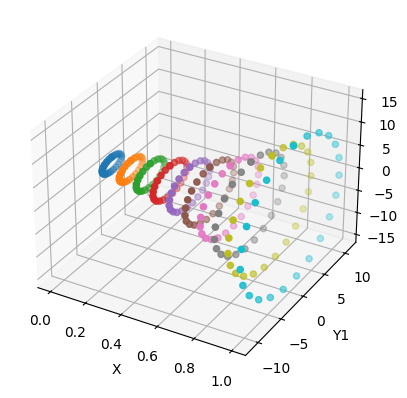

In [104]:
def plot_mainfold(x, y):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    n = y.shape[0]

    for i in range(n):
        ax.scatter(np.full((y.shape[1],), x[i]), y[i, :, 0], y[i, :, 1])
    
    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y1')
    ax.set_zlabel('Y2')
    plt.show()

plot_mainfold(x, y)

### Training ### 
Nice! ok now we will need to compute some sort of energy function, and choose a loss function
such that we can train our system. Our system will only have a neural net in the predictor part, 
which will be combined with our latent variable (theta in this case) to produce our estimate 
$\hat{y}$

In [114]:
# using tensors now so to keep gradient calculations need to convert our functions
# to take in tensors and return tensors

def decoder_manual(z: torch.tensor, f: torch.tensor):
    """
    decodes using our latent variable z and the output of our predictor
    f into our predicted y's
    """
    # arbitrarily come up with some decoder that maps us to an elipsis in 2D
    outputs = torch.zeros(f.shape[0], len(z), 2)
    for i, theta in enumerate(z):
                outputs[:, i, 0] = f[:, 0] * torch.sin(theta)
                outputs[:, i, 1] = f[:, 1] * torch.cos(theta)
    
    return outputs

def energy_func(y: torch.tensor, y_hat: torch.tensor):
    """
    computes the energy function for the given y, z, and w where w are the outputs
    of our neural net 
    """
    return torch.sum((y - y_hat)**2, axis=1)

In [116]:
class Predictor(nn.Module):
    """
    predictor network - we just need a neural network that takes a scalar input (x) 
    and returns a 2D output  (y1, y2)
    """
    def __init__(self):
        super(Predictor, self).__init__()
        self.fc1 = nn.Linear(1, 8)
        self.fc2 = nn.Linear(8, 8)
        self.fc3 = nn.Linear(8, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Now we are going to need to implement our training loop. For now, we will use _Zero Temperature Limit_
Free Energy function $F_{\infty}(y) = min_{z}E(y, z)$, and then the loss function will simply be our energy term, which we will try to minimize. 

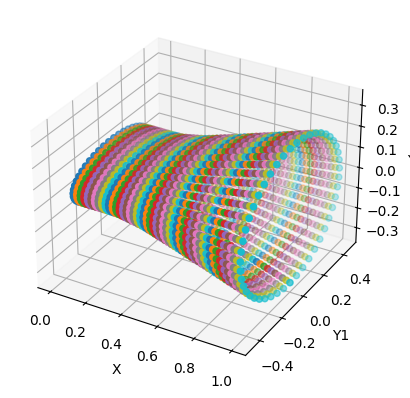

In [112]:
eps = np.finfo(float).eps
theta = torch.linspace(0, 2*np.pi - eps, 48).reshape(-1, 1)
x = torch.linspace(0, 1, 50).reshape(-1, 1)

# print our untrained manifold 
model = Predictor()
f = model(x)
y_hat = decoder_manual(theta, f)
plot_mainfold(x.detach().numpy(), y_hat.detach().numpy())

In [113]:
y = sample_y(x.detach().numpy().squeeze(), theta.detach().numpy())
y = torch.tensor(y).float()

In [122]:
model = Predictor()

In [129]:
TRAINING_ITERATIONS = 10
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
losses = []
for i in range(TRAINING_ITERATIONS):
    f = model(x)
    print(f"output shape = {f.shape}, theta shape = {theta.shape}") 
    y_hat = decoder_manual(theta, f)
    loss = energy_func(y, y_hat).mean()
    print(f'Iteration {i}, Loss: {loss.item()}')
    losses.append(loss.item())
     
    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()


output shape = torch.Size([50, 2]), theta shape = torch.Size([48, 1])
Iteration 0, Loss: 0.9718227982521057
output shape = torch.Size([50, 2]), theta shape = torch.Size([48, 1])
Iteration 1, Loss: 0.9841163754463196
output shape = torch.Size([50, 2]), theta shape = torch.Size([48, 1])
Iteration 2, Loss: 0.9474362730979919
output shape = torch.Size([50, 2]), theta shape = torch.Size([48, 1])
Iteration 3, Loss: 0.958271861076355
output shape = torch.Size([50, 2]), theta shape = torch.Size([48, 1])
Iteration 4, Loss: 0.9241986870765686
output shape = torch.Size([50, 2]), theta shape = torch.Size([48, 1])
Iteration 5, Loss: 0.9336493611335754
output shape = torch.Size([50, 2]), theta shape = torch.Size([48, 1])
Iteration 6, Loss: 0.9023059606552124
output shape = torch.Size([50, 2]), theta shape = torch.Size([48, 1])
Iteration 7, Loss: 0.9104567170143127
output shape = torch.Size([50, 2]), theta shape = torch.Size([48, 1])
Iteration 8, Loss: 0.8813885450363159
output shape = torch.Size([50

So we've trained our model using full gradient descent given the small size. 
An easy way to check on how we are doing is to plot our models predictions for our input
with our latent variable. We will basically just be doing the exact same thing we plotted
before training, and comparing the results. 

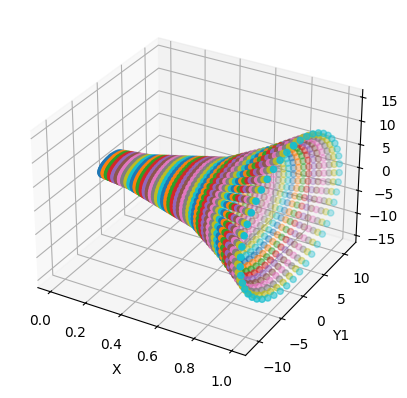

In [124]:
f = model(x)
y_hat = decoder_manual(theta, f)
plot_mainfold(x.detach().numpy(), y_hat.detach().numpy())

### Training with a learnable decoder ### 
Not too bad! We can see how given our latent variable and decoder model, 
we have succesfully learned to draw our points to the manifold of the training data. 

Next, we are going to generalize this by having the decoder also be a neural network instead of our 
manually created elipsis function. this should take a little longer to train, but the results
would be more flexible / general.

In [154]:
INPUT_DIM = 50  # 48 z's per data point (Each with two coordinates)
class Decoder(nn.Module):
    """
    Takes the output of our encoder model which is in R2 and decodes it along 
    with the latent variable z (R1), which represents theta here. We can stack
    these two together to feed into the network. 
    """
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(INPUT_DIM, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 96)  # 48 x 2

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.view(-1, 48, 2)  # reshape to 48 x 2
        return x

In [162]:
predictor = Predictor()
decoder = Decoder()
combined_params = list(predictor.parameters()) + list(decoder.parameters())

Lets print out what our untrained manifold looks like - it should look like a random mess since both networks have not been trained vs before our decoder specifically put us on an elipsis. 

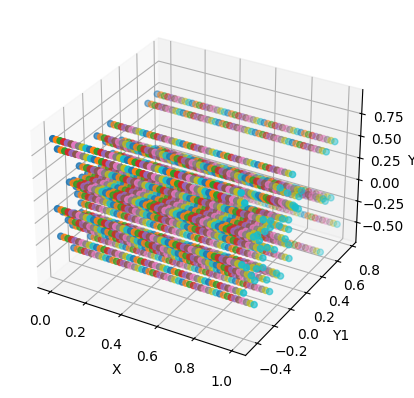

In [163]:

f = predictor(x)
z_expand = theta.repeat(1, f.shape[0]).transpose(0, 1)     
decoder_input = torch.cat((f, z_expand), dim=1)  #n x 50
y_hat = decoder(decoder_input)
plot_mainfold(x.detach().numpy(), y_hat.detach().numpy())

Yup pretty nonsensical (although interesting structure?). Now we can 
re run our training loop but this time run back prop on both the predictor()
and decoder() network to learn the final form of the manifold. As I said before this should
take a bit longer to train, so we will up to 5000 epochs. 

In [164]:
TRAINING_ITERATIONS = 5000
optimizer = torch.optim.SGD(combined_params, lr=1e-3)

for i in range(TRAINING_ITERATIONS):
    optimizer.zero_grad()
    f = predictor(x)
    z_expand = theta.repeat(1, f.shape[0]).transpose(0, 1) 
    
    decoder_input = torch.cat((f, z_expand), dim=1)  #n x 50
    y_hat = decoder(decoder_input)

    loss = energy_func(y, y_hat).mean()
    if i % 500 == 0:
        print(f'Iteration {i}, Loss: {loss.item()}')    
    
    loss.backward()
    optimizer.step()


Iteration 0, Loss: 1023.572021484375
Iteration 500, Loss: 829.6604614257812
Iteration 1000, Loss: 33.59177780151367
Iteration 1500, Loss: 63.262107849121094
Iteration 2000, Loss: 31.773344039916992
Iteration 2500, Loss: 13.679587364196777
Iteration 3000, Loss: 10.424333572387695
Iteration 3500, Loss: 3.1167168617248535
Iteration 4000, Loss: 0.8346304297447205
Iteration 4500, Loss: 0.8559809327125549


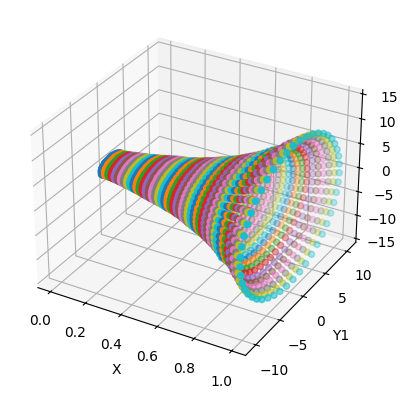

In [161]:
f = predictor(x)
z_expand = theta.repeat(1, f.shape[0]).transpose(0, 1)     
decoder_input = torch.cat((f, z_expand), dim=1)  #n x 50
y_hat = decoder(decoder_input)
plot_mainfold(x.detach().numpy(), y_hat.detach().numpy())

Nice - thats pretty damn cool that we have recovered the manifold at a very similar 
loss to our original network where we explicitly told it how to combine our latent variable and the learned
output of our network. 